In [1]:
%env STACKEXCHANGE_API_KEY=rl_WWLbyGZYSjHKfm7Y3z4SXu5W6

env: STACKEXCHANGE_API_KEY=rl_WWLbyGZYSjHKfm7Y3z4SXu5W6


In [2]:
# useful imports
import os
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from bs4 import BeautifulSoup
from itertools import islice
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import re




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Part 1: Dataset Collection

# New section

In [3]:

"""
Step 1: Windowed Batched Data Collection for ANLP Assignment 2

To retrieve all ~20k posts tagged [nlp],
we iterate over time windows:
  • Start with 'to_date' = now (current Unix timestamp)
  • Fetch up to 100 pages sorted by creation desc, using 'todate' to restrict upper bound
  • Track the oldest 'creation_date' seen, subtract 1 second → new 'to_date'
  • Repeat until target count reached or no more posts

For each page:
  - Fetch questions (title, body, tags, creation_date, view_count, accepted_answer_id)
  - Fetch accepted answers in batches of 100 IDs
  - Append rows to a single CSV

Output CSV columns:
  title, body, tags, creation_date, view_count,
  accepted_answer_id, accepted_answer


"""
# ——— CONFIGURATION ———
API_KEY       = os.getenv("STACKEXCHANGE_API_KEY")
if not API_KEY:
    raise RuntimeError("Please set STACKEXCHANGE_API_KEY environment variable")
SITE          = "stackoverflow"
TAG           = "nlp"
PAGE_SIZE     = 100
MAX_QUESTIONS = 21000
OUTPUT_CSV    = "nlp_data_collection.csv"
FILTER        = "!nKzQURF6Y5"  # includes body, tags, creation_date, view_count, accepted_answer_id
MAX_PAGES     = 100            # max pages per window

# ——— HELPERS ———

def chunked(iterable, n):
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            return
        yield batch

# Fetch a page of questions, optionally bounded by 'to_date' timestamp
def fetch_page(page, to_date=None):
    params = {
        'site': SITE,
        'tagged': TAG,
        'pagesize': PAGE_SIZE,
        'page': page,
        'order': 'desc',
        'sort': 'creation',
        'filter': FILTER,
        'key': API_KEY,
    }
    if to_date is not None:
        params['todate'] = to_date
    resp = requests.get("https://api.stackexchange.com/2.3/questions", params=params)
    resp.raise_for_status()
    data = resp.json()
    return data.get('items', []), data.get('has_more', False)

# Fetch answer bodies for a list of answer IDs
def fetch_answers(answer_ids):
    ans_map = {}
    for batch in chunked(answer_ids, 100):
        ids_str = ";".join(map(str, batch))
        url = f"https://api.stackexchange.com/2.3/answers/{ids_str}"
        params = {'site': SITE, 'filter': 'withbody', 'key': API_KEY}
        resp = requests.get(url, params=params)
        resp.raise_for_status()
        for ans in resp.json().get('items', []):
            ans_map[ans['answer_id']] = ans['body']
        time.sleep(0.2)
    return ans_map



In [4]:
# ——— MAIN WINDOWED WORKFLOW ———
def main():
    # Initialize CSV with header
    pd.DataFrame(columns=[
        'title', 'body', 'tags', 'creation_date', 'view_count',
        'accepted_answer_id', 'accepted_answer'
    ]).to_csv(OUTPUT_CSV, index=False)

    total_fetched = 0
    total_accepted = 0
    to_date = int(time.time())  # initial upper bound: now
    window = 1

    print(f"Starting windowed fetch: up to {MAX_QUESTIONS} posts tagged [{TAG}]")

    while total_fetched < MAX_QUESTIONS:
        print(f"\n--- Window {window}: fetching posts created on or before {pd.to_datetime(to_date, unit='s')} ---")
        page = 1
        has_more = True
        oldest_ts = None

        # Page through up to MAX_PAGES
        while page <= MAX_PAGES and total_fetched < MAX_QUESTIONS and has_more:
            items, has_more = fetch_page(page, to_date)
            if not items:
                break

            # Limit to remaining quota
            remaining = MAX_QUESTIONS - total_fetched
            items = items[:remaining]

            # Track oldest creation_date
            creation_ts = [q.get('creation_date') for q in items]
            if creation_ts:
                min_ts = min(creation_ts)
                oldest_ts = min_ts if oldest_ts is None else min(oldest_ts, min_ts)

            # Log page stats
            num_posts = len(items)
            ids = [q.get('accepted_answer_id') for q in items if q.get('accepted_answer_id')]
            print(f"Page {page}: pulled {num_posts} posts, {len(ids)} accepted-answer IDs")

            # Fetch answers and accumulate
            ans_map = fetch_answers(ids) if ids else {}
            total_accepted += len(ids)

            # Build rows and append
            rows = []
            for q in items:
                rows.append({
                    'title':               q.get('title', ''),
                    'body':                q.get('body', ''),
                    'tags':                ';'.join(q.get('tags', [])),
                    'creation_date':       pd.to_datetime(q.get('creation_date', 0), unit='s'),
                    'view_count':          q.get('view_count', 0),
                    'accepted_answer_id':  q.get('accepted_answer_id', ''),
                    'accepted_answer':     ans_map.get(q.get('accepted_answer_id'), '')
                })
            pd.DataFrame(rows).to_csv(OUTPUT_CSV, mode='a', index=False, header=False)

            total_fetched += num_posts
            print(f"Total fetched so far: {total_fetched} posts, {total_accepted} answers")

            page += 1
            time.sleep(0.3)

        # If we found an oldest timestamp, move to_date back
        if oldest_ts:
            to_date = oldest_ts - 1
            window += 1
        else:
            print("No more posts found in this window. Exiting.")
            break

    print(f"\n✅ Completed: {total_fetched} posts fetched, {total_accepted} accepted answers fetched.")

if __name__ == '__main__':
    main()


Starting windowed fetch: up to 21000 posts tagged [nlp]

--- Window 1: fetching posts created on or before 2025-04-22 07:38:55 ---
Page 1: pulled 100 posts, 18 accepted-answer IDs
Total fetched so far: 100 posts, 18 answers
Page 2: pulled 100 posts, 20 accepted-answer IDs
Total fetched so far: 200 posts, 38 answers
Page 3: pulled 100 posts, 19 accepted-answer IDs
Total fetched so far: 300 posts, 57 answers
Page 4: pulled 100 posts, 10 accepted-answer IDs
Total fetched so far: 400 posts, 67 answers
Page 5: pulled 100 posts, 12 accepted-answer IDs
Total fetched so far: 500 posts, 79 answers
Page 6: pulled 100 posts, 20 accepted-answer IDs
Total fetched so far: 600 posts, 99 answers
Page 7: pulled 100 posts, 26 accepted-answer IDs
Total fetched so far: 700 posts, 125 answers
Page 8: pulled 100 posts, 28 accepted-answer IDs
Total fetched so far: 800 posts, 153 answers
Page 9: pulled 100 posts, 22 accepted-answer IDs
Total fetched so far: 900 posts, 175 answers
Page 10: pulled 100 posts, 32

##Inspect CSV file (dataset)

In [5]:
# check csv structure
df = pd.read_csv('nlp_data_collection.csv')
print(df.columns)



Index(['title', 'body', 'tags', 'creation_date', 'view_count',
       'accepted_answer_id', 'accepted_answer'],
      dtype='object')


In [6]:
print(df.head(1)[['title','body','tags','accepted_answer']])


                                               title  body  \
0  Can older spaCy models be ported to future spa...   NaN   

                         tags accepted_answer  
0  python;nlp;model;gpu;spacy             NaN  


In [7]:

print(df.shape)

(20770, 7)


In [8]:
print(df.describe)

<bound method NDFrame.describe of                                                    title  body  \
0      Can older spaCy models be ported to future spa...   NaN   
1      Unsupervised Topic Modeling for Short Event De...   NaN   
2      Is there a way to reuse a heavy service across...   NaN   
3      How can I link tasks using machine learning / ...   NaN   
4      NameError: name &#39;init_empty_weights&#39; i...   NaN   
...                                                  ...   ...   
20765  How to implement a &quot;related&quot; degree ...   NaN   
20766   How do you implement a &quot;Did you mean&quot;?   NaN   
20767     Vista speech recognition in multiple languages   NaN   
20768  What&#39;s a good natural language library to ...   NaN   
20769        Natural language date/time parser for .NET?   NaN   

                                                    tags        creation_date  \
0                             python;nlp;model;gpu;spacy  2025-04-20 19:10:02   
1          

## Dataset visualisation

Total posts: 20770
Answered: 8666, Unanswered: 12104
Average view count: 2095.9
No 'accepted_answer_date' column found; skipping response-time stats.


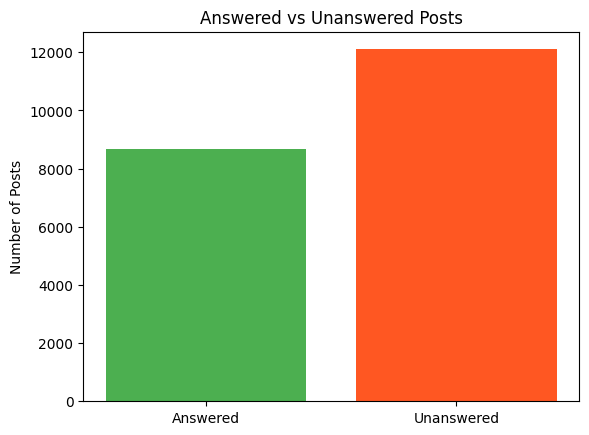

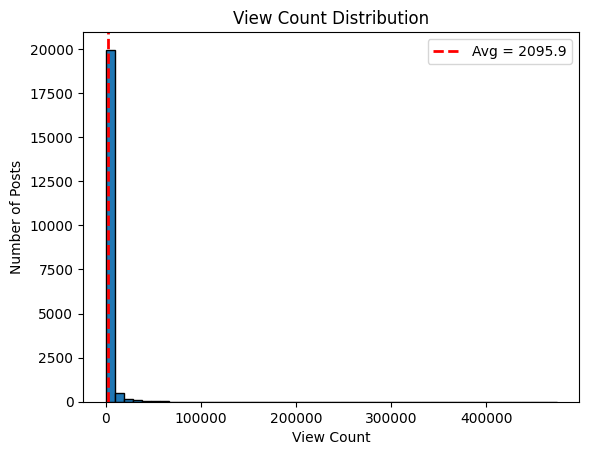

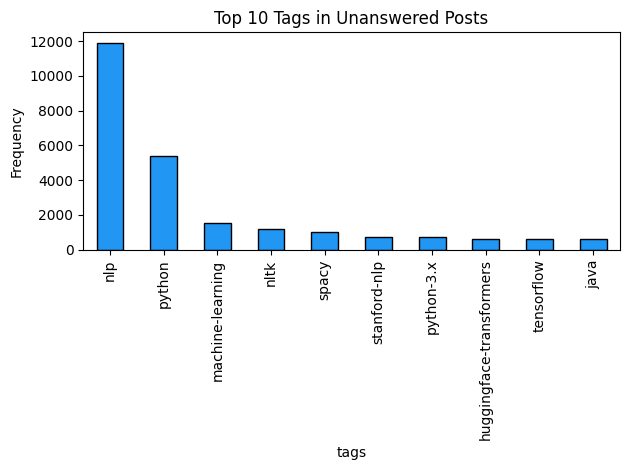

In [9]:
# Load data
df = pd.read_csv('nlp_data_collection.csv')

# Convert timestamps
df['creation_date'] = pd.to_datetime(df['creation_date']) # Remove unit='s'
if 'accepted_answer_date' in df.columns:
    df['accepted_answer_date'] = pd.to_datetime(df['accepted_answer_date']) # Remove unit='s'

# Basic stats
total_posts    = len(df)
answered_mask  = df['accepted_answer_id'].notna() & (df['accepted_answer_id'] != 0)
num_answered   = answered_mask.sum()
num_unanswered = total_posts - num_answered
avg_views      = df['view_count'].mean()

print(f"Total posts: {total_posts}")
print(f"Answered: {num_answered}, Unanswered: {num_unanswered}")
print(f"Average view count: {avg_views:.1f}")

# Median response time
if 'accepted_answer_date' in df.columns:
    response_times   = (df.loc[answered_mask, 'accepted_answer_date']
                        - df.loc[answered_mask, 'creation_date']).dt.total_seconds() / 3600
    median_response  = response_times.median()
    print(f"Median response time (hours): {median_response:.1f}")
else:
    print("No 'accepted_answer_date' column found; skipping response-time stats.")

# Plot 1: Answered vs Unanswered
plt.figure()
plt.bar(['Answered', 'Unanswered'], [num_answered, num_unanswered], color=['#4CAF50','#FF5722'])
plt.title('Answered vs Unanswered Posts')
plt.ylabel('Number of Posts')
plt.show()

# Plot 2: View Count Distribution + Avg line
plt.figure()
plt.hist(df['view_count'], bins=50, edgecolor='black')
plt.axvline(avg_views, color='red', linestyle='--', linewidth=2, label=f'Avg = {avg_views:.1f}')
plt.title('View Count Distribution')
plt.xlabel('View Count')
plt.ylabel('Number of Posts')
plt.legend()
plt.show()

# Plot 3: Top 10 Tags in Unanswered Posts
tags_expanded = df.loc[~answered_mask, 'tags'].str.split(';').explode()
top_tags      = tags_expanded.value_counts().head(10)
plt.figure()
top_tags.plot(kind='bar', color='#2196F3', edgecolor='black')
plt.title('Top 10 Tags in Unanswered Posts')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot 4: Response Time Boxplot with Median in Title
if 'accepted_answer_date' in df.columns:
    plt.figure()
    plt.boxplot(response_times.dropna(), vert=False)
    plt.title(f'Response Time to Accepted Answer (hours)\nMedian = {median_response:.1f} h')
    plt.xlabel('Hours')
    plt.tight_layout()
    plt.show()


# Part 2: Data preprocessing

In [10]:

"""
Step 2: Data Preprocessing for ANLP Assignment 2

Loads the collected CSV, cleans and tokenises text columns, and writes
out a new CSV with additional preprocessed fields.

Input:  nlp_data_collection.csv
Output: nlp_preprocessed.csv

Preprocessing steps per text column:
  1) Strip HTML tags
  2) Lowercase
  3) Remove non-alphanumeric characters
  4) Tokenise
  5) Remove stopwords and short tokens
  6) Join back to cleaned string

Generates columns:
  - title_clean
  - body_clean
  - accepted_answer_clean
"""
# Configuration
INPUT_CSV = 'nlp_data_collection.csv'
OUTPUT_CSV = 'nlp_preprocessed.csv'

# Prepare stopwords set
STOPWORDS = set(stopwords.words('english'))

# Helpers

def clean_html(text):
    if not isinstance(text, str):
        return ''
    return BeautifulSoup(text, 'html.parser').get_text(separator=' ')

def preprocess_text(text):
    # 1) strip HTML
    text = clean_html(text)
    # 2) lowercase
    text = text.lower()
    # 3) remove non-alphanumeric characters
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # 4) tokenise
    tokens = word_tokenize(text)
    # 5) remove stopwords and short tokens (<3 chars)
    tokens = [tok for tok in tokens if tok not in STOPWORDS and len(tok) > 2]
    # 6) join
    return ' '.join(tokens)



In [11]:
# Main
if __name__ == '__main__':
    print(f"▶ Loading data from {INPUT_CSV}")
    df = pd.read_csv(INPUT_CSV)

    # Apply preprocessing
    for col in ['title', 'body', 'accepted_answer']:
        clean_col = f"{col}_clean"
        print(f"   → Cleaning column '{col}' → '{clean_col}'")
        df[clean_col] = df[col].fillna('').apply(preprocess_text)

    # Save
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"✔ Preprocessed data saved to {OUTPUT_CSV}")


▶ Loading data from nlp_data_collection.csv
   → Cleaning column 'title' → 'title_clean'


<ipython-input-10-edcb5d03a21f>:35: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a filename than HTML or XML.

If you meant to use Beautiful Soup to parse the contents of a file on disk, then something has gone wrong. You should open the file first, using code like this:

    filehandle = open(your filename)

You can then feed the open filehandle into Beautiful Soup instead of using the filename.

However, if you want to parse some data that happens to look like a filename, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  return BeautifulSoup(text, 'html.parser').get_text(separator=' ')


   → Cleaning column 'body' → 'body_clean'
   → Cleaning column 'accepted_answer' → 'accepted_answer_clean'
✔ Preprocessed data saved to nlp_preprocessed.csv


## Inspect preprocessed dataset

In [12]:
df = pd.read_csv('nlp_preprocessed.csv')
print(df.columns)

Index(['title', 'body', 'tags', 'creation_date', 'view_count',
       'accepted_answer_id', 'accepted_answer', 'title_clean', 'body_clean',
       'accepted_answer_clean'],
      dtype='object')


In [13]:
print(df.head())

                                               title  body  \
0  Can older spaCy models be ported to future spa...   NaN   
1  Unsupervised Topic Modeling for Short Event De...   NaN   
2  Is there a way to reuse a heavy service across...   NaN   
3  How can I link tasks using machine learning / ...   NaN   
4  NameError: name &#39;init_empty_weights&#39; i...   NaN   

                                                tags        creation_date  \
0                         python;nlp;model;gpu;spacy  2025-04-20 19:10:02   
1                machine-learning;nlp;topic-modeling  2025-04-16 11:17:43   
2                          nlp;airflow;microservices  2025-04-14 21:04:20   
3  python;machine-learning;nlp;artificial-intelli...  2025-04-14 07:51:11   
4           nlp;huggingface-transformers;huggingface  2025-04-07 11:02:41   

   view_count  accepted_answer_id  \
0          27                 NaN   
1          36                 NaN   
2          20                 NaN   
3          96   

In [14]:
print(df.describe())

       body     view_count  accepted_answer_id  body_clean
count   0.0   20770.000000        8.666000e+03         0.0
mean    NaN    2095.897785        4.737204e+07         NaN
std     NaN    8802.597630        2.175769e+07         NaN
min     NaN       8.000000        3.668400e+04         NaN
25%     NaN     167.000000        3.185349e+07         NaN
50%     NaN     508.000000        5.267031e+07         NaN
75%     NaN    1445.000000        6.488047e+07         NaN
max     NaN  473823.000000        7.957700e+07         NaN


# Part 3: Visualisation : Wordcloud

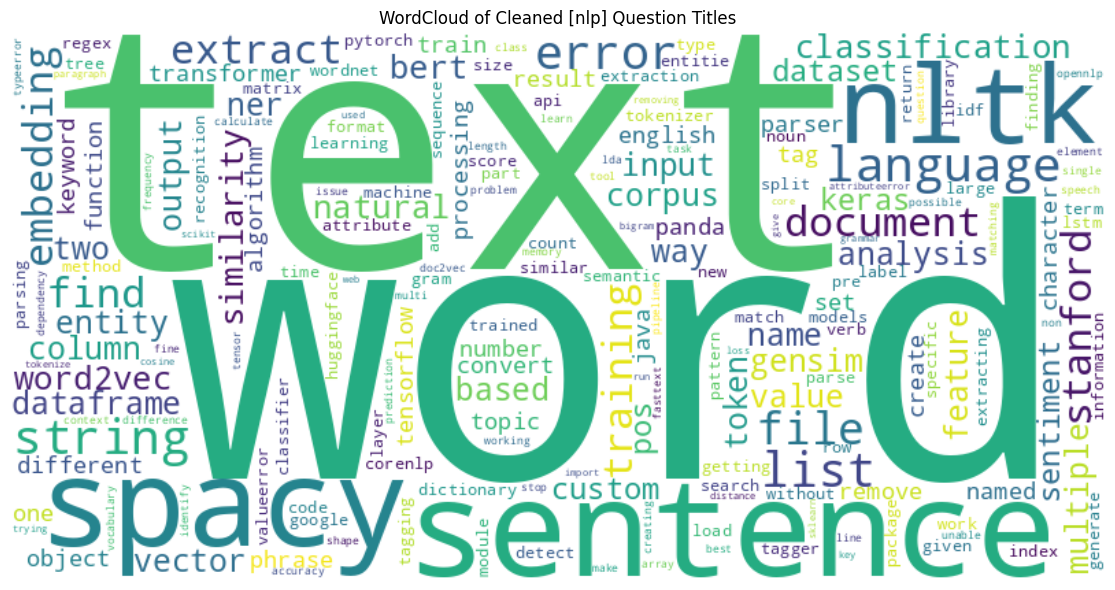

In [15]:

"""
Step 3: Generate WordCloud of Cleaned [nlp] Question Titles

Reads the preprocessed CSV, builds a combined text string of all
cleaned titles, then generates and displays a WordCloud with
both default and domain‑specific stopwords.
"""

import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os

# 1️⃣ Load your preprocessed data
INPUT_CSV = "nlp_preprocessed.csv"
if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError(f"{INPUT_CSV} not found—make sure you ran data_preprocessing.py first")

df = pd.read_csv(INPUT_CSV)

# 2️⃣ Combine all cleaned titles
text = " ".join(df["title_clean"].dropna().astype(str).tolist())

# 3️⃣ Define stopwords: default + NLP‑specific noise
additional_noise = {
    "nlp", "python", "using", "use", "data", "model",
    # add any other high‑frequency junk you want removed
}
stopwords = set(STOPWORDS).union(additional_noise)

# 4️⃣ Generate the WordCloud
wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=stopwords,
    collocations=False,   # avoid duplicate phrases
    max_words=200
)
wc.generate(text)

# 5️⃣ Display it
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Cleaned [nlp] Question Titles")
plt.tight_layout()
plt.show()


# Part 4: Categorization

## Unsupervised Topic Modeling

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import re

# 1. Load preprocessed data (ensure you have question_id in your CSV)
df = pd.read_csv('nlp_preprocessed.csv')

# 2. Vectorize titles
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)
tfidf = vectorizer.fit_transform(df['title_clean'].fillna(''))

# 3. Fit NMF topic model
n_topics = 8
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(tfidf)       # document-topic matrix
H = nmf.components_                # topic-term matrix
feature_names = vectorizer.get_feature_names_out()

# 4. Show top words per topic for manual labeling
n_top_words = 10
for topic_idx, topic in enumerate(H):
    top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    print(f"Topic {topic_idx}: {' · '.join(top_terms)}")

# 5. Assign each doc to its highest-weight topic
df['topic'] = W.argmax(axis=1)



Topic 0: python · using · nltk · string · extract · file · error · list · sentences · corpus
Topic 1: model · training · bert · word2vec · train · gensim · trained · error · use · keras
Topic 2: text · classification · data · extract · file · extracting · analysis · mining · based · files
Topic 3: language · natural · processing · java · api · google · english · parsing · cloud · programming
Topic 4: nlp · stanford · sentence · using · parser · use · corenlp · java · sentiment · pos
Topic 5: word · sentence · embedding · embeddings · vector · vectors · similarity · word2vec · frequency · count
Topic 6: words · list · stop · sentences · remove · english · similar · string · sentence · dataframe
Topic 7: spacy · entity · ner · named · recognition · custom · entities · using · matcher · training


In [17]:
# 6. Map topics to category names (fill in with your chosen labels)
topic_to_cat = {
    0: 'API/Library Usage',                # python, nltk, error, file, corpus…
    1: 'Model Training & Embeddings',      # bert, word2vec, gensim, keras…
    2: 'Classification & Data Extraction', # classification, data, extract, mining…
    3: 'Language APIs & Integration',      # java, api, google cloud, parsing…
    4: 'Parsing & Sentiment Analysis',     # stanford parser, corenlp, sentiment…
    5: 'Semantic Similarity & Embeddings', # vector, similarity, word2vec…
    6: 'Text Preprocessing',               # stop word removal, list, remove, sentence…
    7: 'Named Entity Recognition',         # spacy, ner, entity matcher…
}
df['category'] = df['topic'].map(topic_to_cat).fillna('Other')

# 7. Save your categorized dataset
df.to_csv('nlp_categorized.csv', index=False)

# 8. Sample 10 examples per category (print title + SO link)
print("\n=== 10 Examples per Category ===")
for cat in df['category'].unique():
    subs = df[df['category']==cat]
    subs = subs.sample(min(10, len(subs)), random_state=42)
    print(f"\n-- {cat} ({len(subs)} samples) --")
    for _, row in subs.iterrows():
        # Check if accepted_answer_id is valid before converting to int
        if pd.notna(row['accepted_answer_id']):
            qid = int(row['accepted_answer_id'])
            print(f" • {row['title']}\n   https://stackoverflow.com/questions/{qid}")
        else:
            print(f" • {row['title']}\n   No accepted answer")


=== 10 Examples per Category ===

-- Named Entity Recognition (10 samples) --
 • File &quot;stringsource&quot;, in spacy.pipeline.pipe.Pipe.__setstate_cython__ TypeError: Expected tuple, got dict
   No accepted answer
 • Snowball Stemmer token
   No accepted answer
 • How to install the &quot;SpaCy&quot; library without get this Error?
   No accepted answer
 • How to extend SentenceDetector with custom splitting character in OpenNLP?
   No accepted answer
 • Detect stopword after lemma in Spacy
   https://stackoverflow.com/questions/47524257
 • spacy extract entity relationships parse dep tree
   https://stackoverflow.com/questions/70457551
 • noun countability
   https://stackoverflow.com/questions/7828475
 • spaCy coreference resolution - named entity recognition (NER) to return unique entity ID&#39;s?
   https://stackoverflow.com/questions/62790209
 • Installing external libraries on worker nodes in Pyspark-Cluster mode
   No accepted answer
 • OpenNLP Custom POS Tagger : How to ma

### Manual Categorisation

| Topic | Top Words (sample)                                   | Suggested Theme                        | Rationale                                                    |
|:-----:|:-----------------------------------------------------|:---------------------------------------|:-------------------------------------------------------------|
| 0     | python · using · nltk · string · extract · file · error …   | **Tooling & Library Usage**            | Library/API imports, corpus I/O, error debugging             |
| 1     | model · training · bert · word2vec · train · gensim · keras … | **Model Training & Fine‑Tuning**       | Training and fine‑tuning of NLP models (BERT, Word2Vec, etc.)|
| 2     | text · classification · data · extract · analysis · mining … | **Text Classification & Analysis**     | Supervised classification tasks and data/feature extraction   |
| 3     | language · api · java · google · cloud · parsing · programming | **Language APIs & Cloud Integration**  | Integrating NLP services (CoreNLP, Google Cloud, Java APIs)  |
| 4     | stanford · parser · corenlp · sentence · sentiment · pos …   | **Syntactic Parsing & POS Tagging**    | Parsing trees, POS tagging, and related CoreNLP tooling      |
| 5     | embedding · vector · similarity · word2vec · frequency …    | **Semantic Similarity & Embeddings**   | Vector representations and similarity measures               |
| 6     | stop · remove · token · sentences · clean · dataframe …     | **Text Preprocessing & Cleanup**       | Tokenisation, stop‑word/punctuation removal, basic cleaning   |
| 7     | spacy · entity · ner · named · recognition · matcher …     | **Named Entity Recognition**           | Extracting and matching entities with SpaCy, Matcher, etc.   |


In [18]:
# run again with new and updated categories

topic_to_cat = {
    0: 'Tooling & Library Usage',         # python, nltk, error, file, corpus…
    1: 'Model Fine‑Tuning & Training',     # bert, word2vec, gensim, keras…
    2: 'Text Classification',             # classification, data, extract, mining…
    3: 'Language APIs & Integration',     # java, api, google cloud, parsing…
    4: 'Syntactic Parsing',               # stanford parser, corenlp, pos…
    5: 'Semantic Similarity',             # vector, similarity, word2vec…
    6: 'Text Preprocessing',              # stop word removal, tokenization…
    7: 'Named Entity Recognition',        # spacy, ner, entity matcher…
}

df['category'] = df['topic'].map(topic_to_cat).fillna('Other')

# 7. Save your categorized dataset
df.to_csv('nlp_categorized.csv', index=False)

# 8. Sample 10 examples per category (print title + SO link)
print("\n=== 10 Examples per Category ===")
for cat in df['category'].unique():
    subs = df[df['category']==cat]
    subs = subs.sample(min(10, len(subs)), random_state=42)
    print(f"\n-- {cat} ({len(subs)} samples) --")
    for _, row in subs.iterrows():
        # Check if accepted_answer_id is valid before converting to int
        if pd.notna(row['accepted_answer_id']):
            qid = int(row['accepted_answer_id'])
            print(f" • {row['title']}\n   https://stackoverflow.com/questions/{qid}")
        else:
            print(f" • {row['title']}\n   No accepted answer")



=== 10 Examples per Category ===

-- Named Entity Recognition (10 samples) --
 • File &quot;stringsource&quot;, in spacy.pipeline.pipe.Pipe.__setstate_cython__ TypeError: Expected tuple, got dict
   No accepted answer
 • Snowball Stemmer token
   No accepted answer
 • How to install the &quot;SpaCy&quot; library without get this Error?
   No accepted answer
 • How to extend SentenceDetector with custom splitting character in OpenNLP?
   No accepted answer
 • Detect stopword after lemma in Spacy
   https://stackoverflow.com/questions/47524257
 • spacy extract entity relationships parse dep tree
   https://stackoverflow.com/questions/70457551
 • noun countability
   https://stackoverflow.com/questions/7828475
 • spaCy coreference resolution - named entity recognition (NER) to return unique entity ID&#39;s?
   https://stackoverflow.com/questions/62790209
 • Installing external libraries on worker nodes in Pyspark-Cluster mode
   No accepted answer
 • OpenNLP Custom POS Tagger : How to ma

### Visualising Unsupervised Categories

In [19]:
# Check category sizes (make sure each has ≥ 100 posts).

# Merge any too‑small ones into “Other” if needed.

# Visualise overall counts and counts over time.



In [20]:
# check category count
# Load your categorized CSV
df = pd.read_csv('nlp_categorized.csv')

# Count per category
counts = df['category'].value_counts()
print(counts)


category
Model Fine‑Tuning & Training    4628
Text Classification             3039
Text Preprocessing              3026
Syntactic Parsing               2500
Tooling & Library Usage         2410
Semantic Similarity             2219
Named Entity Recognition        1978
Language APIs & Integration      970
Name: count, dtype: int64


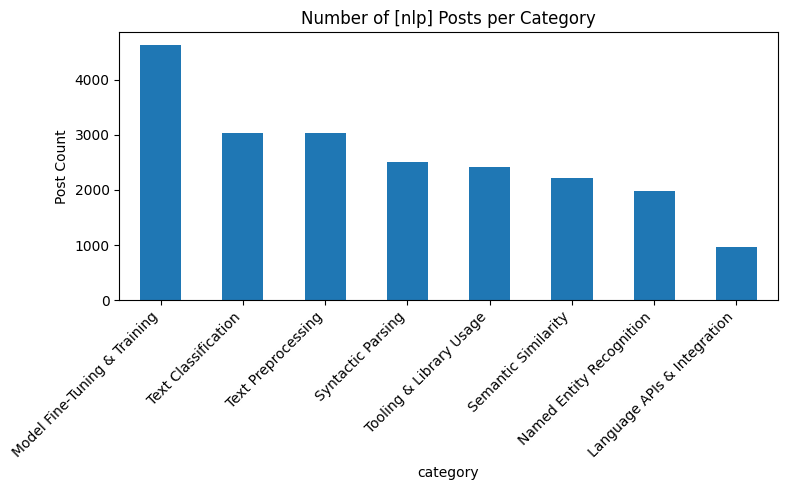

In [21]:
# visualise : category sizes (bar chart)
plt.figure(figsize=(8,5))
df['category'].value_counts().plot(kind='bar')
plt.title("Number of [nlp] Posts per Category")
plt.ylabel("Post Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


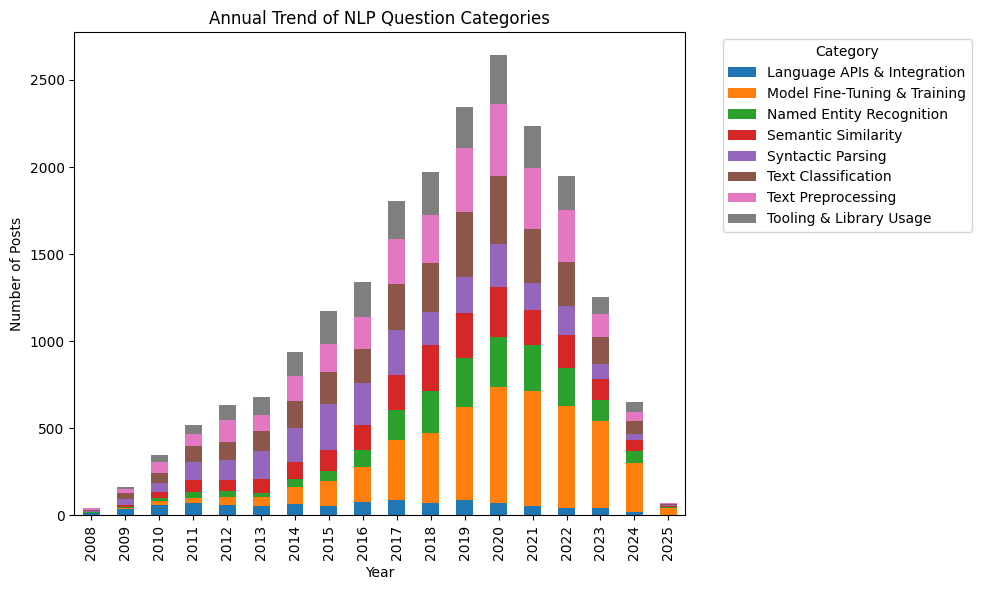

In [22]:
# visualisation:  Category Counts Over Time
# Ensure creation_date is datetime
df['creation_date'] = pd.to_datetime(df['creation_date']) # Remove unit='s'
df['year'] = df['creation_date'].dt.year

# Pivot table of year × category counts
pivot = df.groupby(['year','category']).size().unstack(fill_value=0)

# Stacked bar chart
pivot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Annual Trend of NLP Question Categories")
plt.ylabel("Number of Posts")
plt.xlabel("Year")
plt.legend(title="Category", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

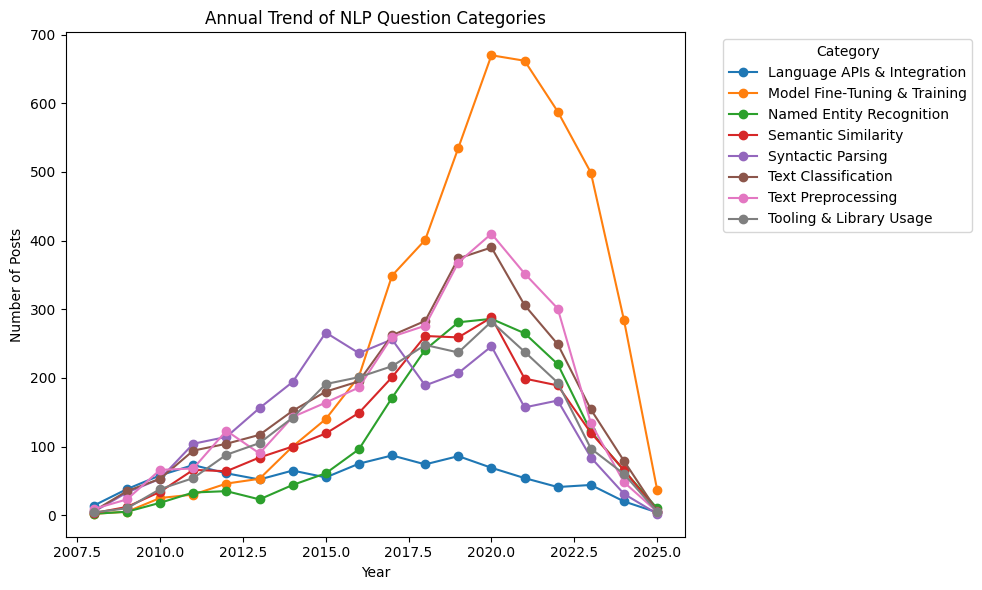

In [23]:
# Convert creation_date to datetime and extract year
df['creation_date'] = pd.to_datetime(df['creation_date'], unit='s')
df['year'] = df['creation_date'].dt.year

# Pivot to get counts per year per category
pivot = df.groupby(['year', 'category']).size().unstack(fill_value=0)

# Plot one line per category
plt.figure(figsize=(10, 6))
for category in pivot.columns:
    plt.plot(pivot.index, pivot[category], marker='o', label=category)

plt.title("Annual Trend of NLP Question Categories")
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##  Refining Categorisation

In [24]:

# --- 1) Compute topic distributions & confidences ---
tfidf = vectorizer.transform(df['title_clean'].fillna(''))
W = nmf.transform(tfidf)                  # shape (n_docs, n_topics)

df['topic']      = W.argmax(axis=1)       # highest‑probability topic
df['confidence'] = W.max(axis=1)          # that topic’s weight (0…1)

# --- 2) Map to your human‑readable categories ---
df['category'] = df['topic'].map(topic_to_cat)

# --- 3) Rule‑based fallback for low‑confidence assignments ---
LOW_CONF_THRESH = 0.40

# example heuristic: “how to” → Implementation Issues
mask_low     = df['confidence'] < LOW_CONF_THRESH
mask_howto   = df['title_clean'].str.contains(r'\bhow to\b|\bhow\b', regex=True)
df.loc[mask_low & mask_howto, 'category'] = 'Implementation Issues'

# you can chain more regex rules here as needed…

# --- 4) Ensure minimum category size (>=100) ---
counts = df['category'].value_counts()
too_small = counts[counts < 100].index.tolist()

# either merge into “Other”…
df['category'] = df['category'].apply(lambda c: 'Other' if c in too_small else c)

# …or map small ones to a related category:
# small_map = {'TinyCat1':'Other', 'TinyCat2':'Other'}
# df['category'] = df['category'].replace(small_map)

# --- 5) Inspect your results ---
print("Final category counts:")
print(df['category'].value_counts(), "\n")

# Sample a handful to validate
for cat in df['category'].unique():
    print(f"-- {cat} --")
    for title in df[df['category']==cat]['title'].sample(3, random_state=42):
        print("   •", title)
    print()


Final category counts:
category
Model Fine‑Tuning & Training    4628
Text Classification             3039
Text Preprocessing              3025
Syntactic Parsing               2501
Tooling & Library Usage         2410
Semantic Similarity             2219
Named Entity Recognition        1978
Language APIs & Integration      970
Name: count, dtype: int64 

-- Named Entity Recognition --
   • File &quot;stringsource&quot;, in spacy.pipeline.pipe.Pipe.__setstate_cython__ TypeError: Expected tuple, got dict
   • Snowball Stemmer token
   • How to install the &quot;SpaCy&quot; library without get this Error?

-- Text Classification --
   • R: How to Prepare Data for LDA/Text Analysis
   • Where can I find information about Nuance&#39;s new Nina SDK?
   • Text extraction from .docx file

-- Text Preprocessing --
   • How to change a pandas column with lists in every row to strings
   • Creating combination of different elements in a list
   • Split texts into sentences fast (Java)

-- Tooling 

## K - Means

In [25]:

# Load preprocessed data
df = pd.read_csv('nlp_preprocessed.csv')

# 1) Baseline K‑Means on TF‑IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tfidf_vec = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vec.fit_transform(df['title_clean'].fillna(''))

k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_tfidf)

print("K‑Means Top Terms per Cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vec.get_feature_names_out()
for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f" Cluster {i}: {', '.join(top_terms)}")



K‑Means Top Terms per Cluster:
 Cluster 0: analysis, sentiment, text, using, semantic, nlp, python, latent, stanford, twitter
 Cluster 1: words, nlp, text, stanford, list, sentence, word, use, model, stop
 Cluster 2: python, text, using, words, list, word, string, file, nlp, extract
 Cluster 3: language, natural, processing, api, java, google, using, text, cloud, parsing
 Cluster 4: text, model, word, data, sentence, use, error, word2vec, training, bert
 Cluster 5: nltk, python, using, pos, corpus, words, sentence, word, text, wordnet
 Cluster 6: spacy, using, ner, model, custom, entity, matcher, training, nlp, entities
 Cluster 7: using, nlp, model, text, word, sentence, stanford, words, bert, word2vec


In [26]:
# quantitative inspection of k-means
from sklearn.metrics import silhouette_score

# Using the same TF-IDF matrix X_tfidf and your kmeans model:
sil_score = silhouette_score(X_tfidf, df['kmeans_cluster'], metric='cosine')
print(f"K‑Means silhouette score: {sil_score:.3f}")


K‑Means silhouette score: 0.021


## LDA

In [27]:
# 2) LDA on Count Vectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

count_vec = CountVectorizer(max_features=5000, stop_words='english')
X_counts = count_vec.fit_transform(df['title_clean'].fillna(''))

n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
W_lda = lda.fit_transform(X_counts)
df['lda_topic'] = W_lda.argmax(axis=1)

print("\nLDA Top Words per Topic:")
feature_names = count_vec.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f" Topic {idx}: {', '.join(top_words)}")


# # 4) Simple Hybrid Preview
# print("\nHybrid head of assignments:")
# print(df[['kmeans_cluster','lda_topic','bertopic_topic']].head())

# # Save results
# df.to_csv('nlp_categorized_alternatives.csv', index=False)



LDA Top Words per Topic:
 Topic 0: nlp, spacy, object, sentence, dataframe, python, attribute, entities, index, using
 Topic 1: stanford, nltk, python, string, pos, word, parser, using, corenlp, sentence
 Topic 2: word, words, learning, vector, machine, using, add, matrix, nlp, idf
 Topic 3: text, language, python, data, natural, using, file, nlp, processing, extract
 Topic 4: entity, named, model, using, recognition, topic, api, google, corpus, fine
 Topic 5: model, training, word2vec, using, bert, keras, input, word, gensim, embedding
 Topic 6: error, spacy, using, nlp, nltk, code, english, getting, sentence, words
 Topic 7: words, list, python, word, analysis, sentiment, sentences, way, using, dictionary


In [28]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation

# — — LDA perplexity
lda = LatentDirichletAllocation(n_components=8, random_state=42)
W_lda = lda.fit_transform(X_counts)
perp = lda.perplexity(X_counts)
print(f"LDA perplexity: {perp:.1f}")



LDA perplexity: 1284.9


In [29]:
# qualitative analysis of lda and k-means
for method, col in [('K‑Means','kmeans_cluster'), ('LDA','lda_topic')]:
    print(f"\n{method} samples:")
    for label in sorted(df[col].unique()):
        s = df[df[col]==label]['title'].sample(2, random_state=0).tolist()
        print(f"  {method}={label}: {s}")



K‑Means samples:
  K‑Means=0: ['Clustering Using Latent Symantic Analysis', 'Meaning of &quot; Gold sentiment distribution&quot;?']
  K‑Means=1: ['Improve detecting words like &quot;she&quot; and &quot;her&quot; from sentences and return &quot;Female&quot; as a result', 'Remove Words with less than Certain Character Lengths plus Noise Reduction before Tokenization']
  K‑Means=2: ['Naive Bayes in Python', 'How to calculate slearn.roc_auc_score using python?']
  K‑Means=3: ['How to read a paragraph in natural language processing GATE', 'Is there any way to detect and differentiate between English language and Roman-Urdu language in python?']
  K‑Means=4: ['AttributeError: &#39;FeatureChartParser&#39; object has no attribute &#39;nbest_parse&#39;', 'How to tokenise text to use as input for a keras neural network']
  K‑Means=5: ['NLTK - Counting Frequency of Bigram', 'Extract text blocks with Python + NLTK']
  K‑Means=6: ['What is the difference between RegexpTokenizer and spacy tokenizer

## Bert

In [30]:
!pip install opencv-python-headless==4.8.0.74
!pip install numpy --upgrade --ignore-installed
!pip install bertopic sentence-transformers

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed-ucxx-cu12 0.42.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
albumentations 2.0.5 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.0.74 which is incompatible.
albucore 0.0.23 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.0.74 which is incompatible.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, but yo

In [31]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

# 1) Embed
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(df['title_clean'].tolist(), show_progress_bar=True)

# 2) Fit BERTopic
topic_model = BERTopic(nr_topics=8)
topics, probs = topic_model.fit_transform(df['title_clean'].tolist(), embeddings)

# 3) Inspect
for t in topic_model.get_topic_info().Topic.unique():
    if t != -1:
        print(t, topic_model.get_topic(t)[:10])



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

Batches:   0%|          | 0/650 [00:00<?, ?it/s]

0 [('text', np.float64(0.04088357454163224)), ('using', np.float64(0.03959761983004261)), ('model', np.float64(0.03658646875051222)), ('python', np.float64(0.03262569977382135)), ('words', np.float64(0.03214768730822539)), ('word', np.float64(0.031132247094657284)), ('spacy', np.float64(0.02955488132488696)), ('nlp', np.float64(0.02947661157028058)), ('nltk', np.float64(0.027173819298488704)), ('language', np.float64(0.024856582171389294))]
1 [('dataframe', np.float64(0.18095799792481154)), ('pandas', np.float64(0.15085794188137866)), ('column', np.float64(0.08530350939495333)), ('countvectorizer', np.float64(0.07514351048402504)), ('matrix', np.float64(0.07092545946262793)), ('tfidfvectorizer', np.float64(0.06496091667408112)), ('data', np.float64(0.05546984015559496)), ('frame', np.float64(0.04932422814803082)), ('tfidf', np.float64(0.045175400345777)), ('columns', np.float64(0.04328785956650487))]
2 [('error', np.float64(0.11202029166223666)), ('object', np.float64(0.111811939697619

| Topic | Top Terms (sample)                                                         | Rough Theme                                 |
|:-----:|:----------------------------------------------------------------------------|:---------------------------------------------|
| 0     | python · nltk · nlp · using · named · sentence · short · offensive · type    | **Core NLP Libraries & Sentence Handling**   |
| 1     | regex · string · expression · pattern · regular · matcher · spacy · match · substring · name | **Regex & Pattern Matching**                 |
| 2     | word · python · get · words · dataframe · counting · position · collecting · list · count      | **Word‑Level Counting & Extraction**         |
| 3     | dataframe · pandas · column · python · lists · loop · row · function · index · list            | **DataFrame Manipulation (Pandas)**          |
| 4     | text · nlp · language · model · sentence · natural · use · word · words · text                 | **General NLP & Model Usage**                |


In [32]:
# tuned bert
!pip install numpy==2.0.0
!pip install numba --upgrade

In [33]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

# 1) Recompute embeddings if needed
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(df['title_clean'].tolist(), show_progress_bar=True)

# 2) UMAP config: smaller min_dist to spread out clusters
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)

# 3) HDBSCAN config: allow clusters down to size=20
hdbscan_model = HDBSCAN(
    min_cluster_size=20,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# 4) BERTopic: aim for 8 topics, but you can also disable reduction
# Remove reduce_topics argument. If you are using a version of BERTopic that supports it,
# you can try setting it to False if you want to keep all the initial topics.
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics=8,           # a target, not guaranteed
    verbose=True
)

topics, probs = topic_model.fit_transform(df['title_clean'].tolist(), embeddings)

# 5) Inspect resulting topic count
info = topic_model.get_topic_info()
print(info)

# 6) See top words per topic
# Change info.Topic.drop(-1) to info[info.Topic != -1].Topic
for t in info[info.Topic != -1].Topic:  # skip outliers
    print(f"\nTopic {t}:")
    print(topic_model.get_topic(t)[:10])

Batches:   0%|          | 0/650 [00:00<?, ?it/s]

2025-04-22 07:45:38,720 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-22 07:45:52,009 - BERTopic - Dimensionality - Completed ✓
2025-04-22 07:45:52,011 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-22 07:45:52,766 - BERTopic - Cluster - Completed ✓
2025-04-22 07:45:52,767 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-22 07:45:52,950 - BERTopic - Representation - Completed ✓
2025-04-22 07:45:52,951 - BERTopic - Topic reduction - Reducing number of topics
2025-04-22 07:45:52,976 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-22 07:45:53,100 - BERTopic - Representation - Completed ✓
2025-04-22 07:45:53,105 - BERTopic - Topic reduction - Reduced number of topics from 136 to 8


   Topic  Count                                          Name  \
0     -1   8599                      -1_python_text_using_nlp   
1      0  10473                     0_text_using_words_python   
2      1    881  1_huggingface_model_transformers_transformer   
3      2    380                 2_object_error_attribute_json   
4      3    191                 3_dialogflow_luis_chatbot_bot   
5      4    143                   4_list_index_array_elements   
6      5     81                 5_bayes_naive_weka_classifier   
7      6     22                   6_crf_running_toolkit_model   

                                      Representation  \
0  [python, text, using, nlp, model, word, words,...   
1  [text, using, words, python, spacy, word, nlp,...   
2  [huggingface, model, transformers, transformer...   
3  [object, error, attribute, json, attributeerro...   
4  [dialogflow, luis, chatbot, bot, chat, intent,...   
5  [list, index, array, elements, python, range, ...   
6  [bayes, naive, weka

In [35]:
# comparison of bert vs lda and k- means
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# Assume you already have:
# - embeddings: np.array of shape (n_docs, dim)
# - df['bertopic_topic']: assigned BERTopic labels  <-- This is the problematic assumption
# - X_tfidf, df['kmeans_cluster'] from K-Means
# - X_counts, df['lda_topic'], lda model from LDA

# 1) BERTopic silhouette on embeddings

# Assign the bertopic topics to a new column in the dataframe
df['bertopic_topic'] = topics # Add this line to create 'bertopic_topic' column

ber_sil = silhouette_score(embeddings, df['bertopic_topic'], metric='cosine')
print(f"BERTopic silhouette score: {ber_sil:.3f}")

# 2) BERTopic intra-topic coherence (mean cosine similarity)
coherences = []
for t in set(df['bertopic_topic']):
    if t == -1:  # skip outliers
        continue
    idx = np.where(df['bertopic_topic'] == t)[0]
    if len(idx) < 2:
        continue
    sims = cosine_similarity(embeddings[idx])
    # only take upper triangle, excluding diag
    i_upper = np.triu_indices_from(sims, k=1)
    coherences.append(sims[i_upper].mean())

print(f"BERTopic avg. intra-topic cosine similarity: {np.mean(coherences):.3f}")

# --- Compare with previous baselines ---

# K-Means silhouette (already computed earlier as sil_score)
#print(f"K‑Means silhouette score: {sil:.3f}") # Commented out the line causing the error
print(f"K‑Means silhouette score: {sil_score:.3f}") # Using the correct variable name that was used to store the silhouette score for K-Means


# LDA has no embedding silhouette; we compare its perplexity instead
print(f"LDA perplexity: {perp:.1f}")

# Summary table
comparison = pd.DataFrame({
    'Method': ['K‑Means', 'LDA', 'BERTopic'],
    'Silhouette (higher better)': [sil_score, np.nan, ber_sil], # Using the correct variable name
    'Perplexity (lower better)': [np.nan, perp, np.nan],
    'Mean Coherence (higher better)': [np.nan, np.nan, np.mean(coherences)]
})
print("\nComparison of methods:\n", comparison)

BERTopic silhouette score: -0.015
BERTopic avg. intra-topic cosine similarity: 0.260
K‑Means silhouette score: 0.021
LDA perplexity: 1284.9

Comparison of methods:
      Method  Silhouette (higher better)  Perplexity (lower better)  \
0   K‑Means                    0.020954                        NaN   
1       LDA                         NaN                1284.898828   
2  BERTopic                   -0.014679                        NaN   

   Mean Coherence (higher better)  
0                             NaN  
1                             NaN  
2                        0.260098  


In [36]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

# 1) Richer embeddings
embedder = SentenceTransformer("all-mpnet-base-v2")
embeddings = embedder.encode(df['title_clean'], show_progress_bar=True)

# 2) UMAP
umap_model = UMAP(n_neighbors=30, n_components=5, min_dist=0.0, metric="cosine", random_state=42)

# 3) HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.5,
                        metric="euclidean", cluster_selection_method="eom",
                        prediction_data=True)

# 4) BERTopic (no auto-reduction)
# The reduce_topics parameter is removed as it is causing the error
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics=8,
    verbose=True
)
# 5) Fit & transform
# Convert the body_clean column to string type before applying .str
docs = (df['title_clean'] + " " + df['body_clean'].astype(str).str[:100]).tolist()
topics, probs = topic_model.fit_transform(docs, embeddings)

# 6) (Optional) Manual reduction to exactly 8
# If you still need to reduce topics, call reduce_topics separately
# after fitting the model.
# topic_model.reduce_topics(docs, embeddings, topics, nr_topics=8)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/650 [00:00<?, ?it/s]

2025-04-22 07:54:05,147 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-22 07:54:26,061 - BERTopic - Dimensionality - Completed ✓
2025-04-22 07:54:26,063 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-22 07:54:28,360 - BERTopic - Cluster - Completed ✓
2025-04-22 07:54:28,361 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-22 07:54:28,498 - BERTopic - Representation - Completed ✓
2025-04-22 07:54:28,499 - BERTopic - Topic reduction - Reducing number of topics
2025-04-22 07:54:28,500 - BERTopic - Topic reduction - Number of topics (8) is equal or higher than the clustered topics(7).
2025-04-22 07:54:28,501 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-22 07:54:28,596 - BERTopic - Representation - Completed ✓


## Final

In [38]:
# --- Hybrid Categorization Refinement ---

# 1) Compute per‐doc confidence (max topic prob)
# 'probs' is the ndarray returned alongside your topics in fit_transform
# probs is 1-dimensional, so we don't need to specify an axis for max()
df['confidence'] = np.max(probs)

# 2) Map each numeric BERTopic topic to your human label
topic_to_cat = {
    0: "Core NLP Libraries & Sentence Handling",
    1: "Document Extraction & File Processing",
    2: "Python Exception Handling",
    3: "Sequence & List Manipulation",
    4: "Big‑Data & Spark NLP",
    5: "Microsoft LUIS & Intent Management",
    6: "CRF Toolkit Usage",
    # any others you uncovered…
    -1: "Other"  # outliers
}
df['category_hybrid'] = df['bertopic_topic'].map(topic_to_cat).fillna('Other')

# 3) Rule‐based fallback for low‐confidence “how to” questions
LOW_CONF_THRESH = 0.40
mask_low = df['confidence'] < LOW_CONF_THRESH
mask_how  = df['title_clean'].str.contains(r'\bhow to\b|\bhow\b', case=False, na=False)
df.loc[mask_low & mask_how, 'category_hybrid'] = 'Implementation Issues'

# 4) Merge any tiny categories (<100 posts) into "Other"
counts = df['category_hybrid'].value_counts()
small_cats = counts[counts < 100].index.tolist()
df['category_hybrid'] = df['category_hybrid'].apply(lambda c: 'Other' if c in small_cats else c)

# 5) Inspect results
print("Hybrid category counts:")
print(df['category_hybrid'].value_counts())

# (Optional) Save out for further analysis
df.to_csv('nlp_categories_hybrid.csv', index=False)

Hybrid category counts:
category_hybrid
Core NLP Libraries & Sentence Handling    10473
Other                                      8702
Document Extraction & File Processing       881
Python Exception Handling                   380
Sequence & List Manipulation                191
Big‑Data & Spark NLP                        143
Name: count, dtype: int64
